# FloralNet

In [ ]:
# Group Members Names, Student IDs and Emails
name1 = "Yuan Chenxuan"
stuID1 = "A0216456A"
email1 = "e0540013@u.nus.edu"

name2 = "Alvin Siah Yi Kai"
stuID2 = "A0214249H"
email2 = "e0518533@u.nus.edu"

name3 = "Kong Ming, Jordan"
stuID3 = "A0216950E"
email3 = "e0540507@u.nus.edu"

name4 = "Lau Jia En"
stuID4 = "A0241181R"
email4 = "e0775779@u.nus.edu"

name5 = "Wong Kin Mun"
stuID5 = "A0233374H"
email5 = "e0725374@u.nus.edu"

name6 = "Yunus Ali"
stuID6 = "A0226596R"
email6 = "e0638882@u.nus.edu"

# Import Libraries

In [ ]:
!pip install optuna
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
# General
import os
import random
import time
import pickle
import shutil
import h5py
import numpy as np
import pandas as pd
import pyarrow as pa
from PIL import Image
from pathlib import Path

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2

# Modelling
import optuna
import tensorflow
from keras.metrics import Precision, Recall, AUC
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, Dense, Flatten, Dropout
from keras_tuner import HyperModel
from keras_tuner import Hyperband
from keras.optimizers import Adam
from keras.callbacks import History, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.metrics import classification_report

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Connect your Google Drive to your Colab file
from google.colab import drive
drive.mount('/content/drive')

# Do remember to create a shortcut to the Project Drive to your Google Drive
!ls "/content/drive/MyDrive/IS4242 Project"

Mounted at /content/drive
'Archive Data'				       model_architecture.png
 best_model.h5				      'Model Experiments'
'Consolidated Information of Flowers.gsheet'   ResultsMap.pk1
 FlowerNetDemo.mkv			      'Testing Data'
'IS4242 Group 02 Project Code.ipynb'	      'Training Data'
'IS4242 Group 02 Project Report.gdoc'	      'Validation Data'
'IS4242 Presentation Slides.gslides'


# Data Pre-Processing

In [ ]:
# Image Pre-processing for Training Data and Validation Data
TrainingImagePath = '/content/drive/MyDrive/IS4242 Project/Training Data'
ValidationImagePath = '/content/drive/MyDrive/IS4242 Project/Validation Data'

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True
)

validation_datagen = ImageDataGenerator(rescale = 1./255)

# Generating the Training Data
training_set = train_datagen.flow_from_directory(
    TrainingImagePath,
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'categorical'
)

# Generating the Validation Data
validation_set = validation_datagen.flow_from_directory(
    ValidationImagePath,
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 972 images belonging to 13 classes.
Found 237 images belonging to 13 classes.


In [ ]:
def count_per_class(path, select_class):
  class_image_count = {}

  for folder in os.listdir(path):
      folder_path = os.path.join(path, folder)
      if os.path.isdir(folder_path):
          num_images = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
          class_image_count[folder] = num_images

  if select_class:
    # Selecting Top 10 Classes
    number_of_classes = 10
    top_classes = sorted(class_image_count.items(), key=lambda item: item[1], reverse=True)[:number_of_classes]
    selected_classes = [class_name for class_name, count in top_classes]
    print(selected_classes)
    return selected_classes
  else:
    # Print the breakdown of images per class
    for class_name, count in sorted(class_image_count.items(), key = lambda x: x[1], reverse = True):
        print(f"Class {class_name}: {count} images")

In [ ]:
# Training Dataset Classes
print("Training Data Set Classes:")
count_per_class(TrainingImagePath, False)
print("=========================")

# Validation Dataset Classes
print("Validation Data Set Classes:")
count_per_class(ValidationImagePath, False)

Training Data Set Classes:
Class Peacock Flower: 137 images
Class Bougainvillea: 112 images
Class Ixora: 112 images
Class Water Jasmine: 111 images
Class White Plumbago: 91 images
Class Ixorideae: 84 images
Class Yellow Elder: 81 images
Class False Bird of Paradise: 50 images
Class Pinwheel Flower: 49 images
Class Chinese Hibiscus: 45 images
Class Parakeet Flower: 40 images
Class Moth Orchid: 32 images
Class Singapore Kopsia: 29 images
Validation Data Set Classes:
Class Peacock Flower: 34 images
Class Bougainvillea: 28 images
Class Ixora: 28 images
Class Water Jasmine: 27 images
Class White Plumbago: 22 images
Class Yellow Elder: 20 images
Class Ixorideae: 20 images
Class Pinwheel Flower: 12 images
Class False Bird of Paradise: 12 images
Class Chinese Hibiscus: 11 images
Class Parakeet Flower: 10 images
Class Singapore Kopsia: 7 images
Class Moth Orchid: 7 images


## Selection of Class Labels


In [ ]:
# Selected Classes
selected_classes = count_per_class(TrainingImagePath, True)

# Generating the Training Data of Selected Classes
training_set = train_datagen.flow_from_directory(
    TrainingImagePath,
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'categorical',
    classes=selected_classes
)

# Generating the Testing Data of Selected Classes
validation_set = validation_datagen.flow_from_directory(
    ValidationImagePath,
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'categorical',
    classes=selected_classes,
    shuffle = False
)

['Peacock Flower', 'Bougainvillea', 'Ixora', 'Water Jasmine', 'White Plumbago', 'Ixorideae', 'Yellow Elder', 'False Bird of Paradise', 'Pinwheel Flower', 'Chinese Hibiscus']
Found 871 images belonging to 10 classes.
Found 213 images belonging to 10 classes.


# Reading Training Data

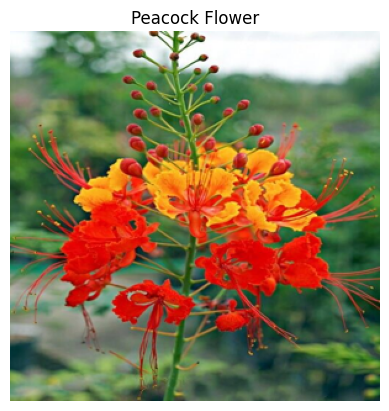

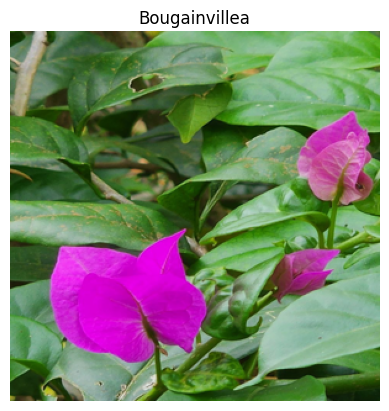

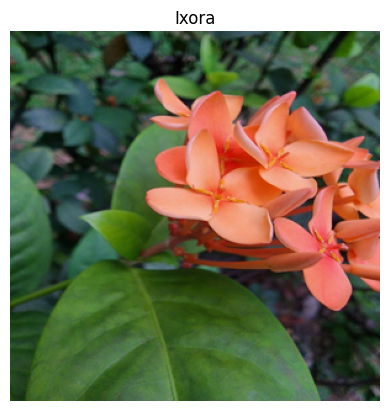

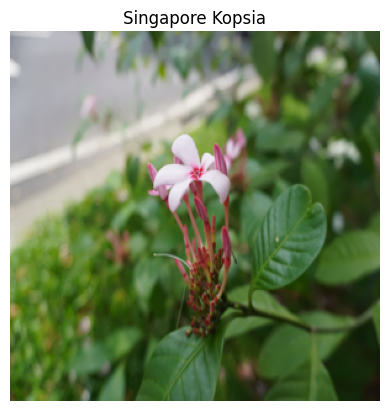

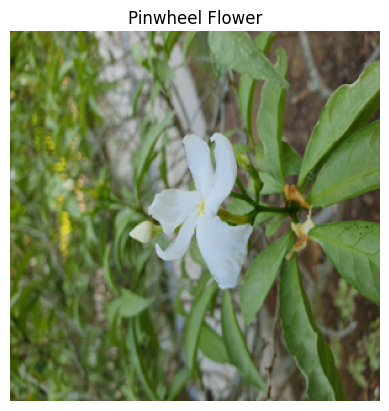

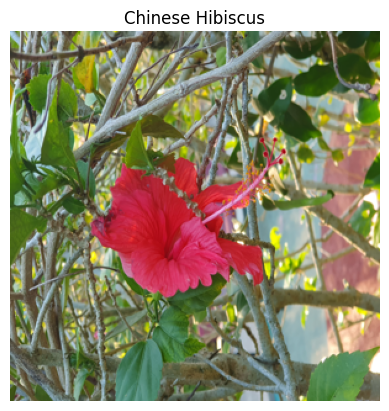

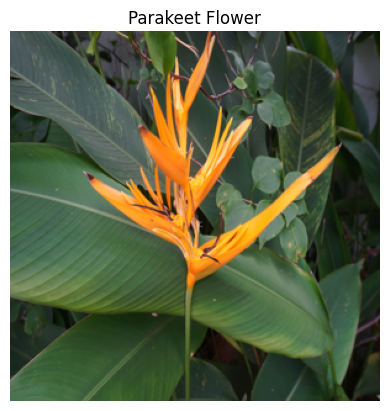

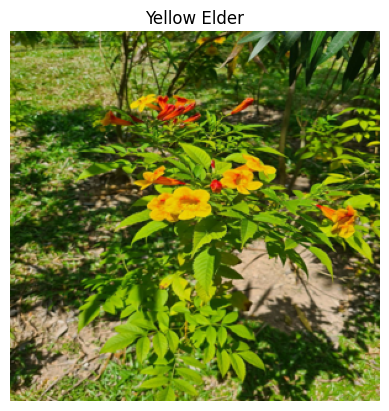

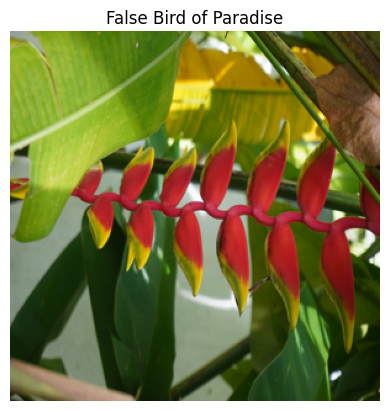

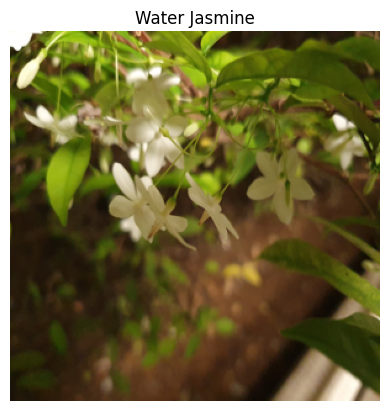

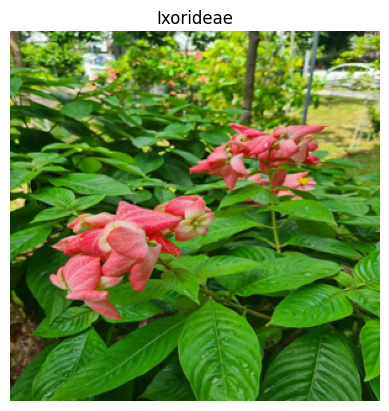

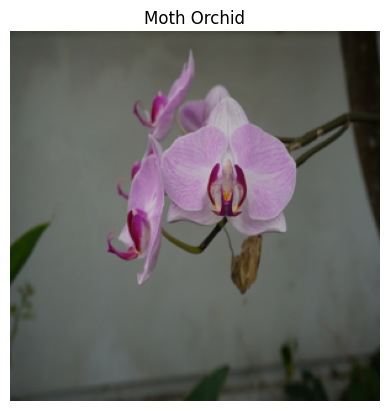

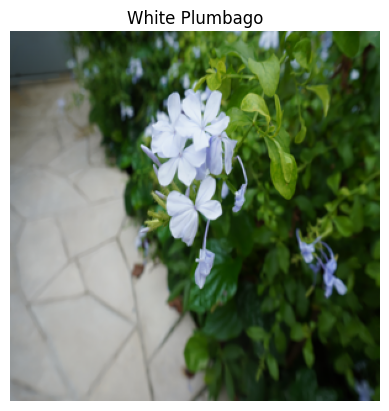

In [ ]:
# Get the list of subdirectories (each subdirectory corresponds to a class)
# Hence, we will just generate the first image of each folder to test if it is working
classes = os.listdir(TrainingImagePath)

for class_name in classes:
  class_dir = os.path.join(TrainingImagePath, class_name)
  image_files = os.listdir(class_dir)

  for image_file in image_files:
    image_path = os.path.join(class_dir, image_file)
    image = Image.open(image_path)
    resized_image = image.resize((300,300))
    plt.imshow(resized_image)
    plt.title(class_name)
    plt.axis(False)
    plt.show()
    break

In [ ]:
training_set.class_indices

{'Peacock Flower': 0,
 'Bougainvillea': 1,
 'Ixora': 2,
 'Water Jasmine': 3,
 'White Plumbago': 4,
 'Ixorideae': 5,
 'Yellow Elder': 6,
 'False Bird of Paradise': 7,
 'Pinwheel Flower': 8,
 'Chinese Hibiscus': 9}

In [ ]:
validation_set.class_indices

{'Peacock Flower': 0,
 'Bougainvillea': 1,
 'Ixora': 2,
 'Water Jasmine': 3,
 'White Plumbago': 4,
 'Ixorideae': 5,
 'Yellow Elder': 6,
 'False Bird of Paradise': 7,
 'Pinwheel Flower': 8,
 'Chinese Hibiscus': 9}

# Creating List of Flowers and Classes

In [ ]:
# Creating lookup table for all flowers
TrainClasses = training_set.class_indices

# Storing the face and numeric tag for future reference
ResultMap = {}
for flowerValue, flowerName in zip(TrainClasses.values(), TrainClasses.keys()):
  ResultMap[flowerValue] = flowerName

# Saving the face map for future reference
with open(R"/content/drive/MyDrive/IS4242 Project/ResultsMap.pk1", 'wb') as f:
  pickle.dump(ResultMap, f, pickle.HIGHEST_PROTOCOL)

print('Mapping of Face and its ID', ResultMap)

OutputNeurons = len(ResultMap)
print('\n The number of output neurons is: ', OutputNeurons)

Mapping of Face and its ID {0: 'Peacock Flower', 1: 'Bougainvillea', 2: 'Ixora', 3: 'Water Jasmine', 4: 'White Plumbago', 5: 'Ixorideae', 6: 'Yellow Elder', 7: 'False Bird of Paradise', 8: 'Pinwheel Flower', 9: 'Chinese Hibiscus'}

 The number of output neurons is:  10


# Exploratory Data Analysis

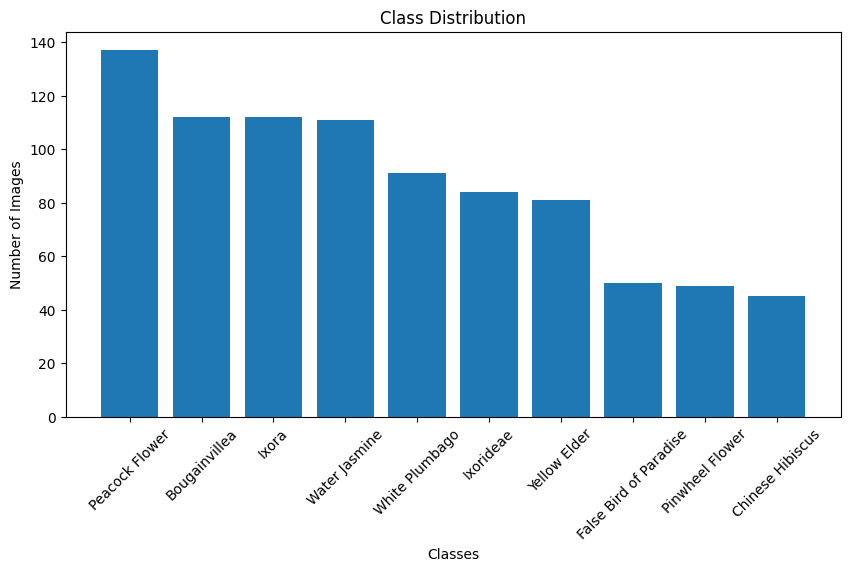

In [ ]:
class_counts = {}
for class_name in TrainClasses:
    class_dir = os.path.join(TrainingImagePath, class_name)
    num_images = len(os.listdir(class_dir))
    class_counts[class_name] = num_images
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()


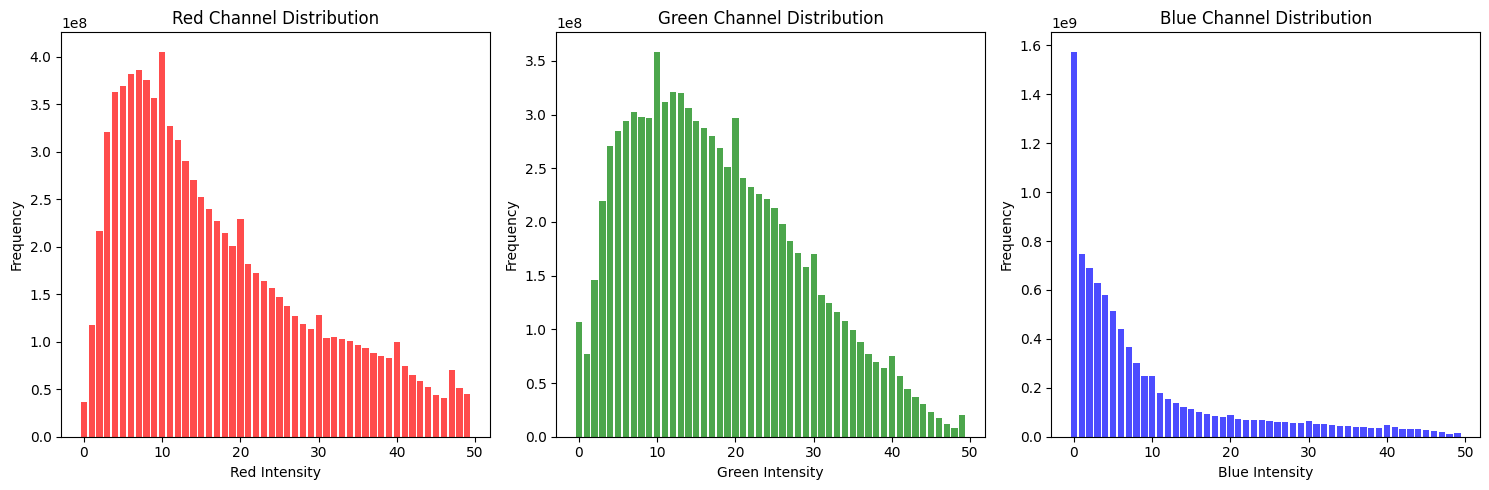

In [ ]:
def plot_color_distribution(data_path):
    classes = os.listdir(data_path)
    num_bins = 50
    red_hist = np.zeros(num_bins)
    green_hist = np.zeros(num_bins)
    blue_hist = np.zeros(num_bins)
    total_images = 0

    for class_name in TrainClasses:
        class_dir = os.path.join(data_path, class_name)
        image_files = os.listdir(class_dir)
        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            image = Image.open(image_path)
            image_array = np.array(image)

            # Compute histograms for each color channel
            red_hist += np.histogram(image_array[:,:,0], bins=num_bins, range=(0, 255))[0]
            green_hist += np.histogram(image_array[:,:,1], bins=num_bins, range=(0, 255))[0]
            blue_hist += np.histogram(image_array[:,:,2], bins=num_bins, range=(0, 255))[0]
            total_images += 1

            # Plot histograms for every 1000 images
            if total_images % 1000 == 0:
                plot_histogram(red_hist, green_hist, blue_hist, num_bins)

    # Plot histograms for the remaining data
    plot_histogram(red_hist, green_hist, blue_hist, num_bins)

def plot_histogram(red_hist, green_hist, blue_hist, num_bins):
    # Plot histograms for each colour channel
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.bar(np.arange(num_bins), red_hist, color='red', alpha=0.7)
    plt.xlabel('Red Intensity')
    plt.ylabel('Frequency')
    plt.title('Red Channel Distribution')

    plt.subplot(1, 3, 2)
    plt.bar(np.arange(num_bins), green_hist, color='green', alpha=0.7)
    plt.xlabel('Green Intensity')
    plt.ylabel('Frequency')
    plt.title('Green Channel Distribution')

    plt.subplot(1, 3, 3)
    plt.bar(np.arange(num_bins), blue_hist, color='blue', alpha=0.7)
    plt.xlabel('Blue Intensity')
    plt.ylabel('Frequency')
    plt.title('Blue Channel Distribution')

    plt.tight_layout()
    plt.show()

# Plot colour distribution
plot_color_distribution(TrainingImagePath)

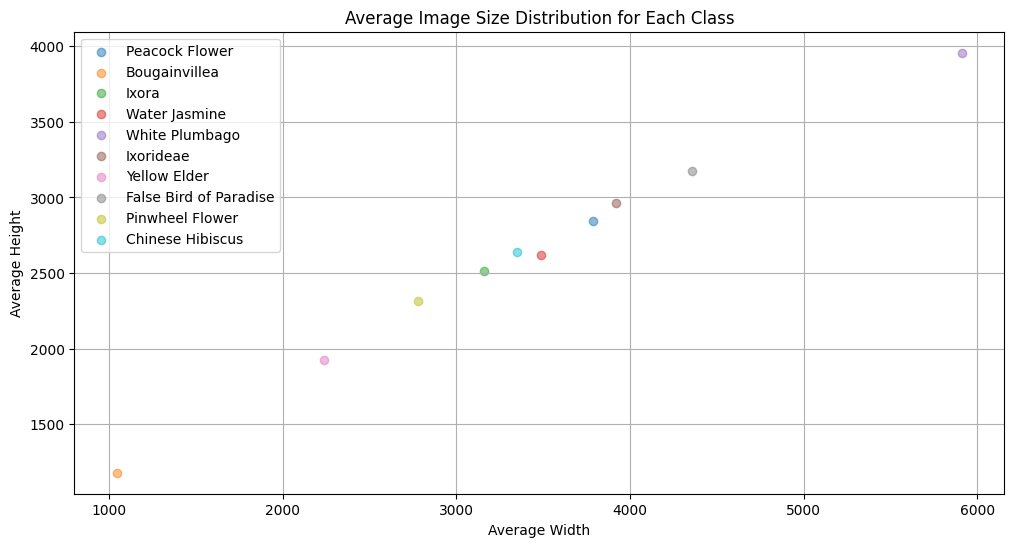

In [ ]:
def get_image_sizes(data_path):
    class_avg_sizes = {}
    classes = os.listdir(data_path)

    for class_name in TrainClasses:
        class_dir = os.path.join(data_path, class_name)
        image_files = os.listdir(class_dir)
        widths = []
        heights = []

        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            image = Image.open(image_path)
            width, height = image.size
            widths.append(width)
            heights.append(height)

        avg_width = sum(widths) / len(widths)
        avg_height = sum(heights) / len(heights)

        class_avg_sizes[class_name] = (avg_width, avg_height)

    return class_avg_sizes

def plot_image_size_distribution(class_avg_sizes):
    plt.figure(figsize=(12, 6))

    for class_name, (avg_width, avg_height) in class_avg_sizes.items():
        plt.scatter(avg_width, avg_height, label=class_name, alpha=0.5)

    plt.title('Average Image Size Distribution for Each Class')
    plt.xlabel('Average Width')
    plt.ylabel('Average Height')
    plt.legend()
    plt.grid(True)
    plt.show()

class_avg_sizes = get_image_sizes(TrainingImagePath)
plot_image_size_distribution(class_avg_sizes)


# Creating CNN Model

## Model Training and Evaluation Utils


### Model Training Variables

In [ ]:
total_train_samples = training_set.samples
batch_size = training_set.batch_size
steps_per_epoch = np.ceil(total_train_samples / batch_size)

early_stopping_monitor = EarlyStopping(monitor = 'val_loss',
                                       patience = 2,
                                       verbose = 1,
                                       restore_best_weights = True
)

total_validation_samples = validation_set.samples
validation_steps = np.ceil(total_validation_samples / batch_size)

### Classification Report

In [ ]:
def class_report(classifier):
  predictions = classifier.predict(validation_set, verbose = 1)
  predicted_classes = np.argmax(predictions, axis = -1)
  true_classes = validation_set.classes

  # Print the shapes and unique counts to verify data integrity
  print("Total predictions:", len(predicted_classes))
  print("Total true labels:", len(true_classes))
  print("Unique predicted classes with counts:", np.unique(predicted_classes, return_counts=True))
  print("Unique true classes with counts:", np.unique(true_classes, return_counts=True))

  # Get the class labels for the classification report
  class_labels = list(validation_set.class_indices.keys())
  report = classification_report(true_classes, predicted_classes, target_names=class_labels)
  print(report)

## Initial CNN Model

In [ ]:
# Old CNN Model with fixed parameters based on intuition
# Different flowers need at least 3 Convolution layers and depth should scale with each layer
def build_model(learning_rate, dropout_rate):
    model = Sequential([

        Convolution2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),


        MaxPooling2D(2, 2),


        Convolution2D(64, (3, 3), activation='relu'),


        MaxPooling2D(2, 2),

        Convolution2D(128, (3, 3), activation='relu'),


        MaxPooling2D(2, 2),


        Flatten(),


        Dense(512, activation='relu'),

        Dropout(dropout_rate),


        Dense(OutputNeurons, activation='softmax')

    ])

    # Compile model with the best learning rate found
    model.compile(optimizer=Adam(learning_rate = learning_rate),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy', Precision(), Recall(), AUC()]
    )
    return model

In [ ]:
old_model = build_model(0.001, 0.5)

In [ ]:
startTime = time.time()

model_history = old_model.fit(training_set,
                               steps_per_epoch = steps_per_epoch,
                               epochs = 6,
                               verbose = 1,
                               validation_data = validation_set,
                               validation_steps = validation_steps,
                               callbacks = [early_stopping_monitor]
)

endTime = time.time()

print("Total Time Taken: ", round((endTime - startTime) / 60), 'Minutes')

In [ ]:
validation_set.reset()

class_report(old_model)

7/7 [==============================] - 38s 5s/step
Total predictions: 213
Total true labels: 213
Unique predicted classes with counts: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([29, 27, 29, 28, 25, 22, 27,  7, 11,  8]))
Unique true classes with counts: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([33, 28, 28, 27, 22, 21, 20, 11, 12, 11]))
                        precision    recall  f1-score   support

        Peacock Flower       1.00      0.88      0.94        33
         Bougainvillea       1.00      0.96      0.98        28
                 Ixora       0.76      0.79      0.77        28
         Water Jasmine       0.96      1.00      0.98        27
        White Plumbago       0.88      1.00      0.94        22
             Ixorideae       0.95      1.00      0.98        21
          Yellow Elder       0.74      1.00      0.85        20
       Pinwheel Flower       1.00      0.64      0.78        11
False Bird of Paradise       0.82      0.75      0.78        12


In [ ]:
# History Keys
history_keys = list(model_history.history.keys())

# Evaluation Metrics for Training Set
train_accuracy = model_history.history[history_keys[1]]
val_accuracy = model_history.history[history_keys[6]]
train_precision = model_history.history[history_keys[2]]
val_precision = model_history.history[history_keys[7]]
train_recall = model_history.history[history_keys[3]]
val_recall = model_history.history[history_keys[8]]
train_f1score = [2 * (train_precision[i] * train_recall[i]) / (train_precision[i] + train_recall[i]) for i in range(len(train_precision))]
val_f1score = [2 * (val_precision[i] * val_recall[i]) / (val_precision[i] + val_recall[i]) for i in range(len(val_precision))]
train_auc = model_history.history[history_keys[4]]
val_auc = model_history.history[history_keys[9]]
train_loss = model_history.history[history_keys[0]]
val_loss = model_history.history[history_keys[5]]

Text(0.5, 1.0, 'Training vs Validation Recall')

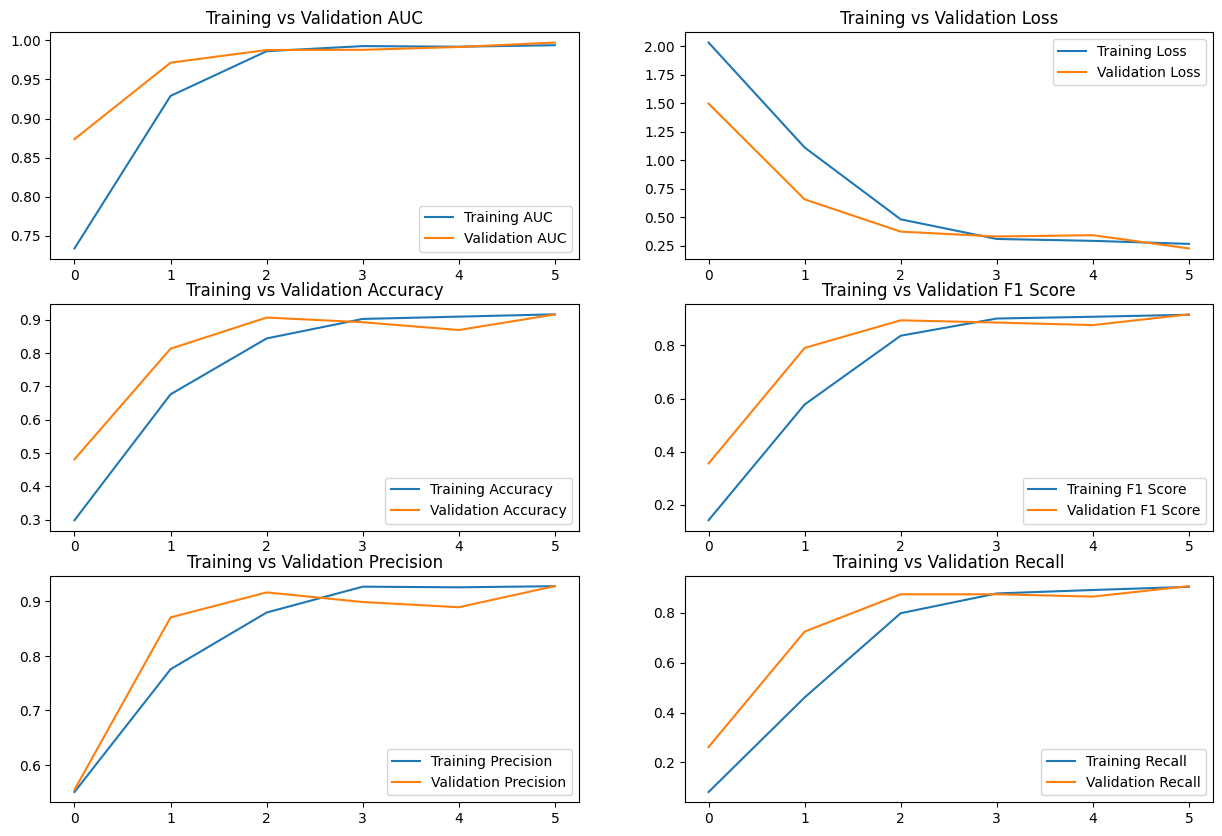

In [ ]:
# Plot Evaluation Metrics
plt.figure(figsize = (15, 10))

# For AUC
plt.subplot(3, 2, 1)
plt.plot(train_auc, label = 'Training AUC')
plt.plot(val_auc, label = 'Validation AUC')
plt.legend()
plt.title('Training vs Validation AUC')

# For Loss
plt.subplot(3, 2, 2)
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')

# For Accuracy
plt.subplot(3, 2, 3)
plt.plot(train_accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# For F1 Score
plt.subplot(3, 2, 4)
plt.plot(train_f1score, label = 'Training F1 Score')
plt.plot(val_f1score, label = 'Validation F1 Score')
plt.legend()
plt.title('Training vs Validation F1 Score')

# For Precision
plt.subplot(3, 2, 5)
plt.plot(train_precision, label = 'Training Precision')
plt.plot(val_precision, label = 'Validation Precision')
plt.legend()
plt.title('Training vs Validation Precision')

# For Recall
plt.subplot(3, 2, 6)
plt.plot(train_recall, label = 'Training Recall')
plt.plot(val_recall, label = 'Validation Recall')
plt.legend()
plt.title('Training vs Validation Recall')

## Model Selection with Hyperparameter Tuning

In [ ]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()

       # Initial Convo Layer
        model.add(Convolution2D(filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
                         kernel_size=hp.Choice('conv1_kernel_size', values=[3, 5]),
                         activation='relu',
                         input_shape=self.input_shape))

        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Subsequent Convo Layers
        num_layers = hp.Int('num_conv_layers', 1, 3)
        for i in range(1, num_layers):
            model.add(Convolution2D(filters=hp.Int(f'conv{i+1}_filters', min_value=32, max_value=128, step=32),
                             kernel_size=hp.Choice(f'conv{i+1}_kernel_size', values=[3, 5]),
                             activation='relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())


        model.add(Dense(
            units=hp.Int('dense_units', min_value=128, max_value=512, step=128),
            activation='relu'
        ))


        model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))


        model.add(Dense(self.num_classes, activation='softmax'))


        model.compile(
            optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
            loss='categorical_crossentropy',
            metrics=['accuracy', Precision(), Recall(), AUC()]
        )

        return model

In [ ]:
input_shape = (128, 128, 3)
num_classes = 10
hypermodel = CNNHyperModel(input_shape=input_shape, num_classes=num_classes)

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='/content/drive/MyDrive/IS4242 Project',
    project_name='Model Experiments'
)

tuner.search(
    training_set,
    steps_per_epoch = steps_per_epoch,
    validation_data = validation_set,
    validation_steps = validation_steps,
    epochs=4,
    callbacks=[early_stopping_monitor]
)


best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

Trial 26 Complete [00h 13m 18s]
val_accuracy: 0.9014084339141846

Best val_accuracy So Far: 0.934272289276123
Total elapsed time: 07h 06m 01s


In [ ]:
# Reset the validation data generator
validation_set.reset()

# Class Report
class_report(best_model)

## Model Architecture Analysis

In [ ]:
print(best_model.layers)
layer_details = []

for layer in best_model.layers:
    config = layer.get_config()

    # Handle Convolutional Layers
    if 'conv' in layer.name:
        layer_details.append({
            'Type': 'Convolutional',
            'Layer Name': layer.name,
            'Depth': layer.filters,
            'Filter Height': layer.kernel_size[0],
            'Filter Width': layer.kernel_size[1],
            'Output Shape': layer.output_shape
        })

    # Handle Pooling Layers
    elif 'pool' in layer.name:
        layer_details.append({
            'Type': 'Pooling',
            'Layer Name': layer.name,
            'Output Shape': layer.output_shape
        })

    # Handle Flatten Layers
    elif 'flatten' in layer.name:
        layer_details.append({
            'Type': 'Flatten',
            'Layer Name': layer.name,
            'Output Shape': layer.output_shape
        })

    # Handle Dense Layers
    elif 'dense' in layer.name:
        layer_details.append({
            'Type': 'Dense',
            'Layer Name': layer.name,
            'Units': layer.units,
            'Activation': config['activation'],
            'Output Shape': layer.output_shape
        })

    # Handle Dropout Layers
    elif 'dropout' in layer.name:
        layer_details.append({
            'Type': 'Dropout',
            'Layer Name': layer.name,
            'Dropout Rate': config['rate'],
            'Output Shape': layer.output_shape
        })

import pprint
pprint.pprint(layer_details)

[<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7a4fa3577220>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7a4fa3577070>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7a4fa3576d10>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7a4fa35757b0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7a4fa35751b0>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7a4fa3552c20>, <keras.src.layers.reshaping.flatten.Flatten object at 0x7a4fa3552350>, <keras.src.layers.core.dense.Dense object at 0x7a4fa36ba410>, <keras.src.layers.regularization.dropout.Dropout object at 0x7a4fb5dd8760>, <keras.src.layers.core.dense.Dense object at 0x7a4fa36b9ab0>]
[{'Depth': 96,
  'Filter Height': 3,
  'Filter Width': 3,
  'Layer Name': 'conv2d',
  'Output Shape': (None, 126, 126, 96),
  'Type': 'Convolutional'},
 {'Layer Name': 'max_pooling2d',
  'Output Shape': (None, 63, 63, 96),
  'Type': 'Pooling'},
 {'Depth': 32,
  'Filter

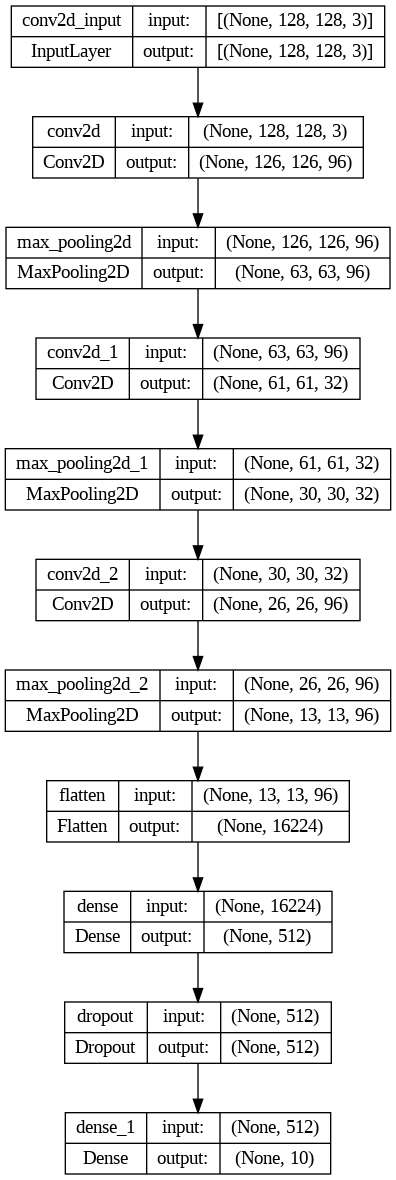

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(classifier, to_file='/content/drive/MyDrive/IS4242 Project/model_architecture.png', show_shapes=True, show_layer_names=True)
Image(filename='/content/drive/MyDrive/IS4242 Project/model_architecture.png')

In [ ]:
for hp in best_hyperparameters.space:
    print(f"{hp.name}: {best_hyperparameters.get(hp.name)}")

num_conv_layers: 3
filters_0: 32
dense_units: 512
dropout_rate: 0.30000000000000004
learning_rate: 0.0011397819243873977
filters_1: 64
conv1_filters: 96
conv1_kernel_size: 3
conv2_filters: 32
conv2_kernel_size: 3
conv3_filters: 96
conv3_kernel_size: 5


## Model Export

In [ ]:
best_model.save('/content/drive/MyDrive/IS4242 Project/best_model.h5')
with open(R"/content/drive/MyDrive/IS4242 Project/best_hyperparameters.pkl", 'wb') as f:
  pickle.dump(best_hyperparameters, f, pickle.HIGHEST_PROTOCOL)

# Testing The Model

In [ ]:
# Load Model
with h5py.File(R"/content/drive/MyDrive/IS4242 Project/best_model.h5", 'r') as f:
    classifier = load_model(f)

In [ ]:
def make_predictions(path, flower):
  test_image = load_img(path, target_size = (128, 128))
  test_image = img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  result = classifier.predict(test_image, verbose = 0)

  image = cv2.imread(path)
  plt.imshow(image)
  plt.title('Flower')
  plt.show()

  print("Predicted: ", ResultMap[np.argmax(result)])
  print(f"Actual: {flower}")

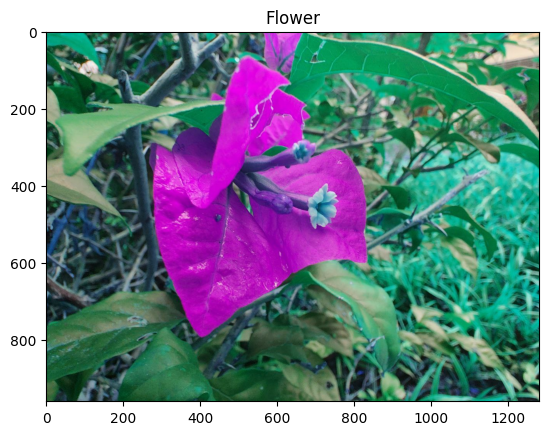

Predicted:  Bougainvillea
Actual: Bougainvillea


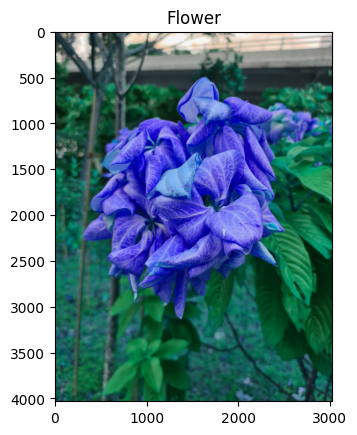

Predicted:  Ixorideae
Actual: Ixorideae


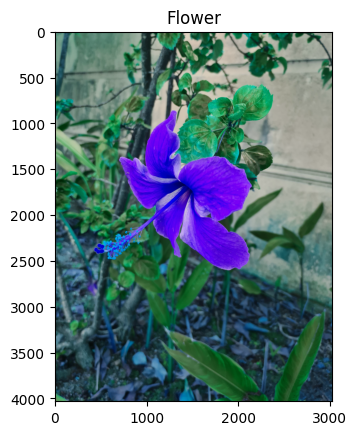

Predicted:  Chinese Hibiscus
Actual: Chinese Hibiscus


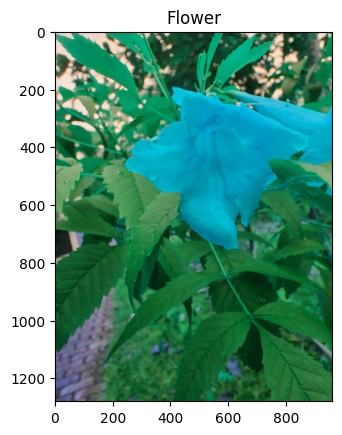

Predicted:  Yellow Elder
Actual: Yellow Elder


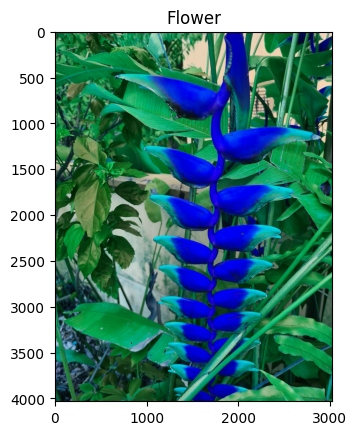

Predicted:  False Bird of Paradise
Actual: False Bird Of Paradise


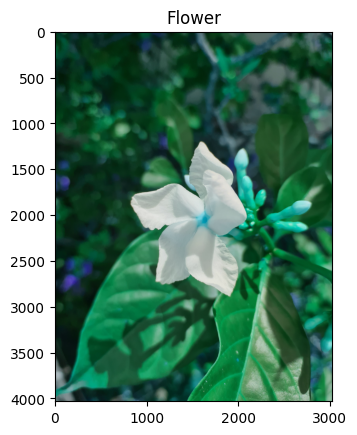

Predicted:  Pinwheel Flower
Actual: Pinwheel Flower


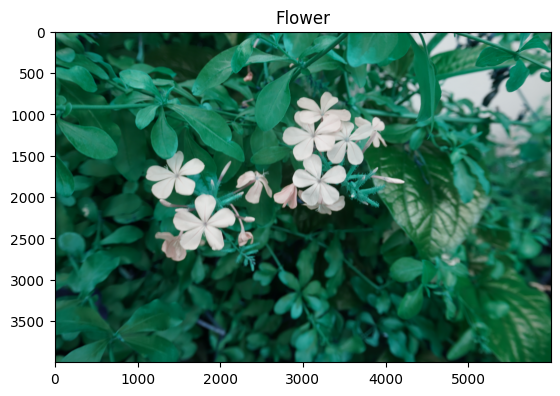

Predicted:  Pinwheel Flower
Actual: White Plumbago


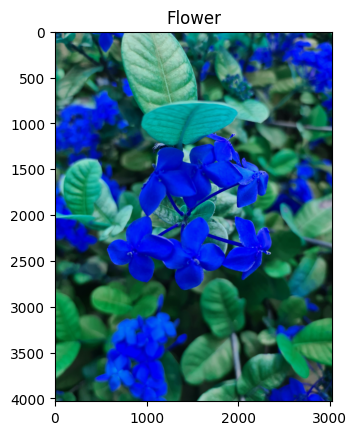

Predicted:  Ixora
Actual: Ixora


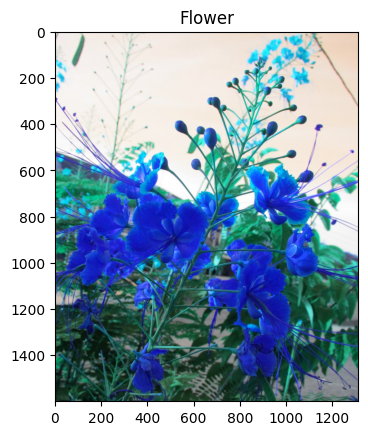

Predicted:  False Bird of Paradise
Actual: Peacock Flower


In [ ]:
# Try Prediction
TestingImagePath = '/content/drive/MyDrive/IS4242 Project/Testing Data'

for filename in os.listdir(TestingImagePath):
    if os.path.isfile(os.path.join(TestingImagePath, filename)):
        filepath = str(Path(TestingImagePath) / filename)
        base_name, extension = os.path.splitext(filename)
        make_predictions(filepath, base_name)